In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 49.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=ab0c8830d3776ae7b6ac94d4d34116a7fe072c98f883b414a402f1d1597394db
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [3]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2022-06-07 12:59:41--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 52.202.168.65, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  12.9MB/s    in 1.0s    

2022-06-07 12:59:42 (12.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]



In [4]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [5]:
!./ngrok authtoken BC5qqC51ENoxrfj2AA9g_xmWSMTcVA11QY1h3RCDp

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [6]:
get_ipython().system_raw('./ngrok http 4050 &')

In [7]:
from pyspark.sql import SparkSession


spark = SparkSession.builder\
        .master('local[4]')\
        .appName('Lesson_2')\
        .config('spark.ui.port', '4050')\
        .config('spark.executor.instances', 2)\
        .config('spark.executor.memory', f'{int(6000/1.1)}mb')\
        .config('spark.executor.cores', 2)\
        .getOrCreate()

sc = spark.sparkContext

In [8]:
spark

In [9]:
rdd = sc.parallelize(['After all is', 'said and', 'done more is', 'said than done'])
print(f'Кол-во партиций: {rdd.getNumPartitions()}')

Кол-во партиций: 4


In [10]:
sc.parallelize([[1], [1, 2, 3,], 'asdf']).collect()

[[1], [1, 2, 3], 'asdf']

In [11]:
rdd.toLocalIterator

<bound method RDD.toLocalIterator of ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:274>

In [12]:
rdd.take(2), rdd.collect()

(['After all is', 'said and'],
 ['After all is', 'said and', 'done more is', 'said than done'])

In [13]:
rdd.glom().collect()

[['After all is'], ['said and'], ['done more is'], ['said than done']]

In [14]:
rdd.coalesce(3).glom().collect()

[['After all is'], ['said and'], ['done more is', 'said than done']]

In [15]:
rdd.repartition(3).glom().collect()

[[], ['After all is', 'done more is'], ['said and', 'said than done']]

In [16]:
rdd\
    .flatMap(lambda row: row.split(' ')) \
    .map(lambda token: (token, 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .take(10)

[('After', 1),
 ('and', 1),
 ('is', 2),
 ('said', 2),
 ('more', 1),
 ('than', 1),
 ('all', 1),
 ('done', 2)]

In [17]:
python_dict = rdd\
    .flatMap(lambda row: row.split(' ')) \
    .map(lambda token: (token, 1)) \
    .countByKey()

In [18]:
sc.parallelize(list(python_dict))

ParallelCollectionRDD[20] at readRDDFromFile at PythonRDD.scala:274

In [19]:
rdd = rdd\
    .flatMap(lambda row: row.split())\
    .map(lambda row: (row, 1))\
    .reduceByKey(lambda a, b: a + b)

In [20]:
rdd.collect()

[('After', 1),
 ('and', 1),
 ('is', 2),
 ('said', 2),
 ('more', 1),
 ('than', 1),
 ('all', 1),
 ('done', 2)]

In [21]:
rdd.sortByKey().collect()

[('After', 1),
 ('all', 1),
 ('and', 1),
 ('done', 2),
 ('is', 2),
 ('more', 1),
 ('said', 2),
 ('than', 1)]

In [22]:
!ls

ngrok  ngrok-stable-linux-amd64.zip  sample_data


In [23]:
!pwd

/content


In [24]:
def beautiful_print(rdd, num, title):
    print(title)
    for row in rdd.take(num):
        print('\t', row)

In [44]:
train = sc.textFile('/content/train.csv')
beautiful_print(train, 3, 'Train:')
train_first_row = train.first()
print(f"Train size: {train.count()} x {len(train_first_row.split(','))}")

Train:
	 battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
	 842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
	 1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
Train size: 2001 x 21


In [45]:
test = sc.textFile('/content/test.csv')
beautiful_print(test, 6, 'Test:')
test_first_row = test.first()
print(f"Test size: {test.count()} x {len(test_first_row.split(','))}")

Test:
	 id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
	 1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
	 2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
	 3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
	 4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
	 5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1
Test size: 1001 x 21


In [46]:
train = train\
    .filter(lambda row: row != train_first_row)\
    .map(lambda row: [float(el) for el in row.split(',')])
    
train_header = train_first_row.split(',')
beautiful_print(train, 3, train_header)

['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range']
	 [842.0, 0.0, 2.2, 0.0, 1.0, 0.0, 7.0, 0.6, 188.0, 2.0, 2.0, 20.0, 756.0, 2549.0, 9.0, 7.0, 19.0, 0.0, 0.0, 1.0, 1.0]
	 [1021.0, 1.0, 0.5, 1.0, 0.0, 1.0, 53.0, 0.7, 136.0, 3.0, 6.0, 905.0, 1988.0, 2631.0, 17.0, 3.0, 7.0, 1.0, 1.0, 0.0, 2.0]
	 [563.0, 1.0, 0.5, 1.0, 2.0, 1.0, 41.0, 0.9, 145.0, 5.0, 6.0, 1263.0, 1716.0, 2603.0, 11.0, 2.0, 9.0, 1.0, 1.0, 0.0, 2.0]


In [47]:
train = train\
    .map(lambda row: row[:-1])
    
train_header = train_header[:-1]
beautiful_print(train, 3, train_header)

['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']
	 [842.0, 0.0, 2.2, 0.0, 1.0, 0.0, 7.0, 0.6, 188.0, 2.0, 2.0, 20.0, 756.0, 2549.0, 9.0, 7.0, 19.0, 0.0, 0.0, 1.0]
	 [1021.0, 1.0, 0.5, 1.0, 0.0, 1.0, 53.0, 0.7, 136.0, 3.0, 6.0, 905.0, 1988.0, 2631.0, 17.0, 3.0, 7.0, 1.0, 1.0, 0.0]
	 [563.0, 1.0, 0.5, 1.0, 2.0, 1.0, 41.0, 0.9, 145.0, 5.0, 6.0, 1263.0, 1716.0, 2603.0, 11.0, 2.0, 9.0, 1.0, 1.0, 0.0]


In [48]:
test = test\
    .filter(lambda row: row != test_first_row)\
    .map(lambda row: [float(el) for el in row.split(',')])
    
test_header = test_first_row.split(',')
beautiful_print(test, 3, test_header)

['id', 'battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']
	 [1.0, 1043.0, 1.0, 1.8, 1.0, 14.0, 0.0, 5.0, 0.1, 193.0, 3.0, 16.0, 226.0, 1412.0, 3476.0, 12.0, 7.0, 2.0, 0.0, 1.0, 0.0]
	 [2.0, 841.0, 1.0, 0.5, 1.0, 4.0, 1.0, 61.0, 0.8, 191.0, 5.0, 12.0, 746.0, 857.0, 3895.0, 6.0, 0.0, 7.0, 1.0, 0.0, 0.0]
	 [3.0, 1807.0, 1.0, 2.8, 0.0, 1.0, 0.0, 27.0, 0.9, 186.0, 3.0, 4.0, 1270.0, 1366.0, 2396.0, 17.0, 10.0, 10.0, 0.0, 1.0, 1.0]


In [49]:
test = test\
    .map(lambda row: row[1:])
    
test_header = test_header[1:]
beautiful_print(test, 3, test_header)

['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']
	 [1043.0, 1.0, 1.8, 1.0, 14.0, 0.0, 5.0, 0.1, 193.0, 3.0, 16.0, 226.0, 1412.0, 3476.0, 12.0, 7.0, 2.0, 0.0, 1.0, 0.0]
	 [841.0, 1.0, 0.5, 1.0, 4.0, 1.0, 61.0, 0.8, 191.0, 5.0, 12.0, 746.0, 857.0, 3895.0, 6.0, 0.0, 7.0, 1.0, 0.0, 0.0]
	 [1807.0, 1.0, 2.8, 0.0, 1.0, 0.0, 27.0, 0.9, 186.0, 3.0, 4.0, 1270.0, 1366.0, 2396.0, 17.0, 10.0, 10.0, 0.0, 1.0, 1.0]


In [50]:
print(f"Train size: {train.count()} x {len(train_header)}")
print(f"Test size: {test.count()} x {len(test_header)}")

Train size: 2000 x 20
Test size: 1000 x 20


In [51]:
union_header = test_header
union = test.union(train)

In [52]:
beautiful_print(union, 3, union_header)
print(f"Test size: {union.count()} x {len(union_header)}")

['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']
	 [1043.0, 1.0, 1.8, 1.0, 14.0, 0.0, 5.0, 0.1, 193.0, 3.0, 16.0, 226.0, 1412.0, 3476.0, 12.0, 7.0, 2.0, 0.0, 1.0, 0.0]
	 [841.0, 1.0, 0.5, 1.0, 4.0, 1.0, 61.0, 0.8, 191.0, 5.0, 12.0, 746.0, 857.0, 3895.0, 6.0, 0.0, 7.0, 1.0, 0.0, 0.0]
	 [1807.0, 1.0, 2.8, 0.0, 1.0, 0.0, 27.0, 0.9, 186.0, 3.0, 4.0, 1270.0, 1366.0, 2396.0, 17.0, 10.0, 10.0, 0.0, 1.0, 1.0]
Test size: 3000 x 20


In [53]:
test_header, train_header

(['battery_power',
  'blue',
  'clock_speed',
  'dual_sim',
  'fc',
  'four_g',
  'int_memory',
  'm_dep',
  'mobile_wt',
  'n_cores',
  'pc',
  'px_height',
  'px_width',
  'ram',
  'sc_h',
  'sc_w',
  'talk_time',
  'three_g',
  'touch_screen',
  'wifi'],
 ['battery_power',
  'blue',
  'clock_speed',
  'dual_sim',
  'fc',
  'four_g',
  'int_memory',
  'm_dep',
  'mobile_wt',
  'n_cores',
  'pc',
  'px_height',
  'px_width',
  'ram',
  'sc_h',
  'sc_w',
  'talk_time',
  'three_g',
  'touch_screen',
  'wifi'])

In [54]:
col_sc_h_num = test_header.index('sc_h')
col_sc_w_num = test_header.index('sc_w')
col_height_num = test_header.index('px_height')
col_width_num = test_header.index('px_width')

In [55]:
format = union\
    .map(lambda row: (row[col_width_num], row[col_height_num]))\
    .filter(lambda row: row[1] != 0)\
    .map(lambda row: ('widescreen', 1) if row[0] / row[1] >= (16 / 9) else ('not widescreen', 1))\
    .reduceByKey(lambda x, y: x + y)\
    .sortByKey()

In [56]:
format.collect()

[('not widescreen', 1359), ('widescreen', 1637)]

In [39]:
import pandas as pd

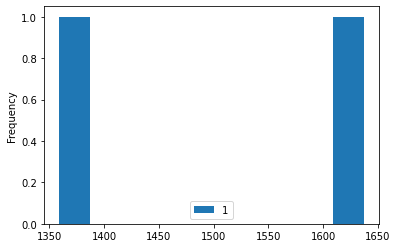

In [57]:
pd.DataFrame(format.collect()).plot.hist()

In [58]:
from numpy.ma.core import sqrt
formats = union\
    .map(lambda row: (row[col_width_num], row[col_height_num]))\
    .filter(lambda row: row[1] != 0)\
    .map(lambda row: ('widescreen', 1) if (sqrt(pow(row[0], 2) + pow(row[1], 2)) / 96.358115) >= (sqrt(pow(16, 2) + pow(9, 2)) / 96.358115) else ('not widescreen', 1))\
    .reduceByKey(lambda x, y: x + y)\
    .sortByKey()

In [59]:
formats.collect()

[('widescreen', 2996)]

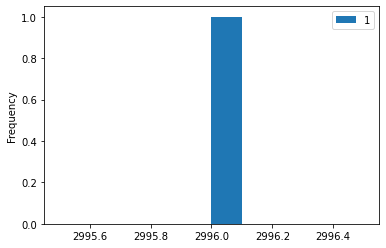

In [60]:
pd.DataFrame(formats.collect()).plot.hist()

In [61]:
train_formats = train \
    .filter(lambda row: row[col_height_num] != 0)\
    .map(lambda row: (int(round(row[col_width_num] / row[col_height_num], 0)), 1) )\
    .reduceByKey(lambda x, y: x + y)\
    .sortByKey()

In [62]:
test_formats = test \
    .filter(lambda row: row[col_height_num] != 0)\
    .map(lambda row: (int(round(row[col_width_num] / row[col_height_num], 0)), 1) )\
    .reduceByKey(lambda x, y: x + y)\
    .sortByKey()

In [63]:
test_formats.take(2)

[(1, 327), (2, 305)]

In [64]:
train_formats.join(test_formats).take(1)

[(4, (122, 58))]

In [66]:
train_formats.cogroup(test_formats).map(lambda row: (row[0], row[1][0].data[0] + row[1][1].data[0])).take(10)

[(4, 180),
 (8, 46),
 (12, 20),
 (16, 9),
 (20, 10),
 (24, 3),
 (28, 7),
 (32, 2),
 (36, 4),
 (40, 3)]

In [68]:
def save_to_csv(row):
  row = ', '.join(row)
  return row + '\n'

sc.parallelize(train_header).union(union.map(save_to_csv))

UnionRDD[135] at union at NativeMethodAccessorImpl.java:0